In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.patheffects as pe

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
#Load in Wage and Point Tally Data
wage_data = pd.read_excel('Wages_2013-2020.xlsx')
tables = pd.read_excel('Final Tables 2013-2020.xlsx')

In [4]:
#Grab point tallies from the Premier League since 2014, format teams to match wage data
prem_tables = tables[(tables.league == 'Premier League') & (tables.year > 2013)]
prem_tables = prem_tables.groupby('team').sum()
prem_tables.index = prem_tables.index.str.lower()
prem_tables.index = prem_tables.index.str.replace(' ', '-').str.replace('west-brom', 'west-bromwich').str.replace('stoke', 'stoke-city').str.replace('man', 'manchester').str.replace('utd', 'united')
prem_tables

,Unnamed: 0,points,year
team,,,
arsenal,30,471,14119
aston-villa,61,145,8068
bournemouth,64,211,10085
brighton,59,158,8074
burnley,78,260,12104
cardiff,17,34,2018
chelsea,21,505,14119
crystal-palace,83,311,14119
everton,60,366,14119


In [5]:
#Grab wage data from the Premier League since 2014
wage_data_period = wage_data[wage_data.Year > 2013]
prem = wage_data_period[wage_data_period.League == 'Premier League']

#Check how many years each team was in the prem since 2014
def num_years(team):
    return len(wage_data_period[wage_data_period.Team == team].Year.unique())
#Grab points
def total_points(team):
    return prem_tables.loc[team].points
#Color mapping - if a team has a better point rank than wage rank, return green; red vise versa
def get_color(point_rank, wage_rank):
    if point_rank - wage_rank < 0:
        return 'green'
    if point_rank - wage_rank > 0:
        return 'red'
    else:
        return 'blue'
    
#Group point table by team
prem_grouped = prem.groupby('Team').sum()
prem_grouped = prem_grouped.reset_index()
#Create column of number of years in Prem
prem_grouped['num_years'] = prem_grouped.Team.apply(lambda x: num_years(x))
#Create column for average salary
prem_grouped['average_salary'] = prem_grouped['Salary (€/year)'] / prem_grouped['num_years']
#Filter out teams that were in Prem for less than 2 years
prem_grouped = prem_grouped[prem_grouped.num_years > 2]
#Sort by average wage bill
prem_grouped = prem_grouped.sort_values('average_salary', ascending = True)
#Grab points tally from point tally table
prem_grouped['total_points'] = prem_grouped.Team.apply(lambda x: total_points(x))
#Points per millions of Euro spent
prem_grouped['points_per_million'] = (prem_grouped.total_points / prem_grouped['Salary (€/year)'])*1000000
#Average points per year
prem_grouped['avg_points'] = prem_grouped.total_points / prem_grouped.num_years
#Rank teams by their average wage bill, add as column
prem_grouped['wage_rank'] = prem_grouped['average_salary'].rank(ascending = False)
#Rank teams by their average point tally, add as column
prem_grouped['points_rank'] = prem_grouped['avg_points'].rank(ascending = False)
#Map color based on over/under performance
prem_grouped['color'] = prem_grouped.index.map(lambda x: get_color(prem_grouped.points_rank.loc[x], prem_grouped.wage_rank.loc[x]))
prem_grouped

,Team,Unnamed: 0,Salary (€/year),Year,num_years,average_salary,total_points,points_per_million,avg_points,wage_rank,points_rank,color
4,burnley,2653,237590092,363095,6,3.959835e+07,260,1.094322,43.333333,22.0,15.0,green
25,swansea,2556,189715993,292248,4,4.742900e+07,177,0.932974,44.250000,21.0,14.0,green
2,bournemouth,3663,240209104,385203,5,4.804182e+07,211,0.878401,42.200000,20.0,17.0,green
28,west-bromwich,2680,256878418,334722,5,5.137568e+07,189,0.735757,37.800000,19.0,20.0,red
24,sunderland,2283,159248800,237778,3,5.308293e+07,101,0.634228,33.666667,18.0,22.0,red
27,watford,3744,269412973,393298,5,5.388259e+07,210,0.779472,42.000000,17.0,18.0,red
23,stoke-city,2056,215573810,262024,4,5.389345e+07,182,0.844258,45.500000,16.0,12.0,green
3,brighton,2492,219587986,286611,4,5.489700e+07,158,0.719529,39.500000,15.0,19.0,red
1,aston-villa,2462,220286388,282322,4,5.507160e+07,145,0.658234,36.250000,14.0,21.0,red
30,wolverhampton,1540,171358653,193810,3,5.711955e+07,161,0.939550,53.666667,13.0,8.0,green


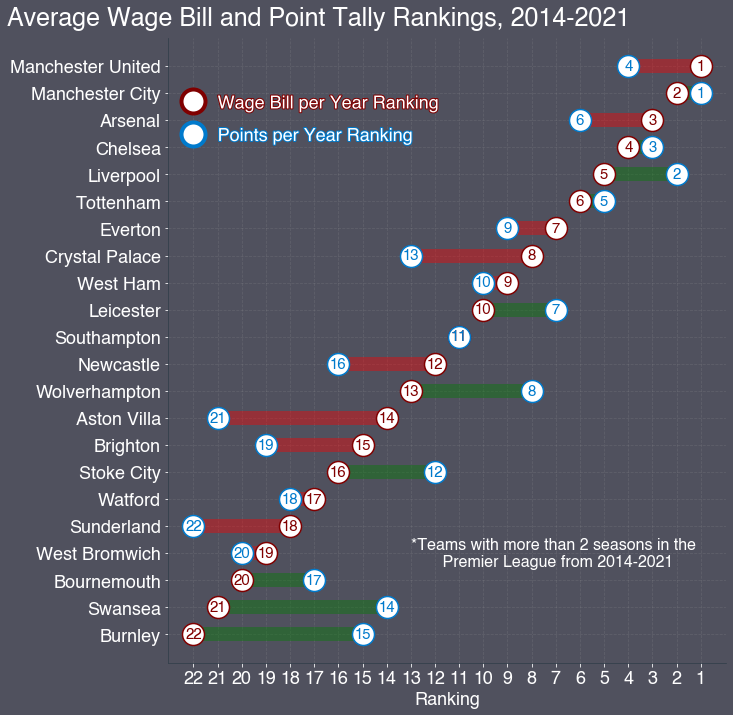

In [15]:
#Base Formatting (Font, axes, facecolor, etc.)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='white'
plt.rcParams['ytick.color']='white'
plt.rcParams['axes.facecolor']='#50515e'
plt.rcParams['savefig.facecolor']='#50515e'

fig, ax = plt.subplots(figsize=(10, 11.5), facecolor = '#50515e')

#Create a range for x and y axes
my_range=list(range(1, len(prem_grouped.index)+1))

#Plot Points for Wage Bill per Year Ranking, and Points per Year Ranking
#Subtract 23 and take the absolute value to flip Points so the further right is a better ranking
plt.plot(abs(prem_grouped['wage_rank'] - 23), my_range, "o", markersize=22, markerfacecolor='w', markeredgewidth=1.5, markeredgecolor= '#800000')
plt.plot(abs(prem_grouped['points_rank'] - 23), my_range, "o", markersize=22, markerfacecolor='w', markeredgewidth=1.5, markeredgecolor= '#007acc')

#Plot lines for each team, where the line starts at their wage rank and ends at their points rank, color code based on over/under performance
plt.hlines(y=my_range, xmin= abs(prem_grouped['wage_rank'] - 23), xmax= abs(prem_grouped['points_rank'] - 23), color= prem_grouped['color'], alpha=0.4, linewidth=14)

#Number each Wage Rank Circle
for i, txt in enumerate(prem_grouped['wage_rank']):
    plt.annotate('{:.0f}'.format(txt), (my_range[i], abs(prem_grouped['wage_rank'] - 23).iloc[i]), ha='center', va = 'center', color = '#800000', size = 15)
#Number each point Tally Circle
for i, txt in enumerate(prem_grouped['points_rank']):
    plt.annotate('{:.0f}'.format(txt), (abs(prem_grouped['points_rank'] - 23).iloc[i], my_range[i]), ha='center', va = 'center', color = '#007acc', size = 15)

#Format axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(range(1, 23), range(22, 0, -1))
plt.yticks(my_range, list(prem_grouped.Team.str.title().str.replace('-', ' '))) 

#Plot Custom Legend

#Plot Marker
plt.plot(1, 20.7, "o", markersize=24, markerfacecolor='w', markeredgewidth=4, markeredgecolor= '#800000')
#Plot text - path_effects allows us to have the edgecolor on the text
plt.annotate('Wage Bill per Year Ranking', (2, 20.6), ha='left', va = 'center', size = 18, color= 'white', path_effects=[pe.withStroke(linewidth=2, foreground='#800000')])
plt.plot(1, 19.5, "o", markersize=24, markerfacecolor='w', markeredgewidth=4, markeredgecolor= '#007acc')
plt.annotate('Points per Year Ranking', (2, 19.4), ha='left', va = 'center', size = 18, color= 'white', path_effects=[pe.withStroke(linewidth=2, foreground="#007acc")])

#Additional text, titles, formatting
plt.annotate('*Teams with more than 2 seasons in the \n Premier League from 2014-2021', (16, 4), ha='center', va = 'center', size = 16, color= 'white')
ax.set_xlabel('Ranking', fontsize=18, fontweight='black', color = 'white')
plt.grid(linestyle = '--', alpha = .17)
plt.title('Average Wage Bill and Point Tally Rankings, 2014-2021', fontsize=25, y=1.01, x = .27, color = 'white')
ax.tick_params(axis='both', which='major', labelsize=18)

#Save fig with bbox_inches - 'tight' to include everything in the file
plt.savefig('points_performance.png', bbox_inches= 'tight')